# Table of Contents
- [Comparing the Regression: Regression Analysis](#comparing-the-regression-regression-analysis)  
  - [Regression Graph](#regression-graph)  
- [Shap Analysis](#shap-analysis)  
  - [Shap Stacked Force Plot](#shap-stacked-force-plot)  
  - [Absolute Mean Shap](#absolute-mean-shap)  
  - [Shap Beeswarm](#shap-beeswarm)  


In [1]:
# Step 1: Import necessary libraries

# Core Libraries
import numpy as np  
import pandas as pd  

# Machine Learning Models
from catboost import CatBoostRegressor, Pool  

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  

# Data Processing
from sklearn.model_selection import train_test_split  

# Visualization
import matplotlib.pyplot as plt  
import seaborn as sns  
import shap  

# Statistical Analysis
from scipy.stats import linregress  


C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def score(actual_values, predicted_values):
    mae_score = mean_absolute_error(actual_values, predicted_values)
    R2_score = r2_score(actual_values,predicted_values)
    MSE = mean_squared_error(actual_values,predicted_values)
    return {"MAE":mae_score, "R2_score":R2_score, "RMSE":np.sqrt(MSE)}


In [3]:
# Step 2: Load dataset
data_filepath = r"Wiley.csv"

data = pd.read_csv(data_filepath)
# remove
# data = data.drop(['Index','Unnamed: 16'], axis=1)
data = data.drop(['Index','Unnamed: 16',], axis=1)
print(data.info())

X = data.drop('fc (MPa)',axis=1)
y = data['fc (MPa)']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cement (kg/m3)  785 non-null    float64
 1   SF (kg/m3)      785 non-null    float64
 2   BFS (kg/m3)     785 non-null    float64
 3   FA (kg/m3)      785 non-null    float64
 4   QP (kg/m3)      785 non-null    float64
 5   LSP (kg/m3)     785 non-null    float64
 6   NS (kg/m3)      785 non-null    float64
 7   Fiber (kg/m3)   785 non-null    float64
 8   Sand (kg/m3)    785 non-null    float64
 9   Gravel (kg/m3)  785 non-null    int64  
 10  Water (kg/m3)   785 non-null    float64
 11  SP (kg/m3)      785 non-null    float64
 12  T (oC)          785 non-null    int64  
 13  RH (%)          785 non-null    int64  
 14  Age (days)      785 non-null    int64  
 15  fc (MPa)        785 non-null    float64
dtypes: float64(12), int64(4)
memory usage: 98.3 KB
None


# Comparing the regression : Regression analysis

### Inferior model that is supposed to have 0.95 of r2 score

In [4]:
categorical_columns = []
numerical_columns = []

for column in data.columns:
  if data[column].nunique() < 10:
    categorical_columns.append(column)
  else:
    numerical_columns.append(column)
numerical_columns = numerical_columns[:-1]

print(f"Categorical Columns: {categorical_columns}")
print(f"Numerical Columns: {numerical_columns}")

# prompt: make sure that all categorical columns are of int type
X = data.drop('fc (MPa)', axis=1)  
y = data['fc (MPa)']

import pandas as pd
for column in categorical_columns:
  X[column] = X[column].astype(int)

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

inferior_model = CatBoostRegressor(verbose=0)

categorical_features = categorical_columns  # Replace with your actual categorical column names
# Create CatBoost Pool objects for training and validation data
train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_data = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)

# Fit the model on the training data with early stopping based on validation data
inferior_model.fit(train_data, eval_set=test_data, early_stopping_rounds=100)


Categorical Columns: ['Fiber (kg/m3)', 'T (oC)', 'RH (%)', 'Age (days)']
Numerical Columns: ['Cement (kg/m3)', 'SF (kg/m3)', 'BFS (kg/m3)', 'FA (kg/m3)', 'QP (kg/m3)', 'LSP (kg/m3)', 'NS (kg/m3)', 'Sand (kg/m3)', 'Gravel (kg/m3)', 'Water (kg/m3)', 'SP (kg/m3)']


In [6]:
y_train_pred = inferior_model.predict(X_train)
y_valid_pred = inferior_model.predict(X_valid)

print(score(y_train,y_train_pred))
print(score(y_valid,y_valid_pred))

{'MAE': 4.0771371757983, 'R2_score': 0.9803453683027944, 'RMSE': 5.6401580893808205}
{'MAE': 5.8740390395839235, 'R2_score': 0.9581229665718, 'RMSE': 8.098094389305468}


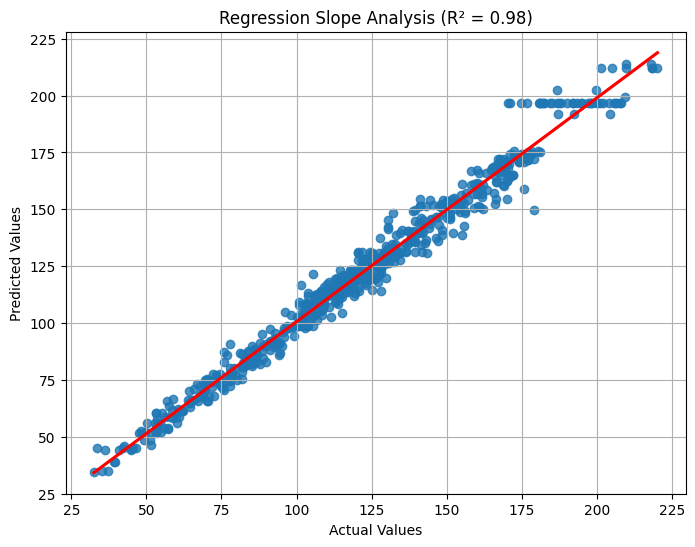

In [9]:
# Perform linear regression on y_valid and y_pred
slope, intercept, r_value, p_value, std_err = linregress(y_train, y_train_pred)

# Print the regression equation
equation = f"y = {slope:.3f}x + {intercept:.3f}"

# Calculate the R-squared value for reference
r2 = r2_score(y_train, y_train_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.regplot(x=y_train, y=y_train_pred, ci=None, line_kws={"color": "red"})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Regression Slope Analysis (R² = {r2:.2f})")
plt.grid(True)
plt.show()


### Model with best performance

In [10]:
model = CatBoostRegressor(
        learning_rate=0.22869040199677768,
        depth= 6,
        l2_leaf_reg=35.017911205405085,
        bagging_temperature = 5.742635616391028,
        subsample=0.6313237463236754,
        border_count=146,
        iterations=2117,
        verbose=0
    )

X = data.drop('fc (MPa)', axis=1)  
y = data['fc (MPa)']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# Fit the model on the training data with early stopping based on validation data
model.fit(X_train,y_train)


In [11]:
y_train_pred_best = model.predict(X_train)
y_valid_pred_best = model.predict(X_valid)

print(score(y_train,y_train_pred_best))
print(score(y_valid,y_valid_pred_best))

{'MAE': 1.778552179865081, 'R2_score': 0.9928490180531504, 'RMSE': 3.4020576040524135}
{'MAE': 3.9342763323438414, 'R2_score': 0.9804748779156685, 'RMSE': 5.529575079380724}


### Regression Graph

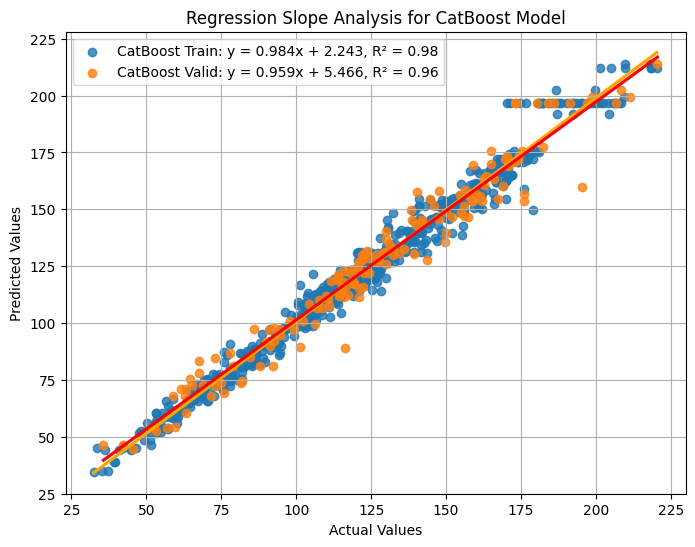

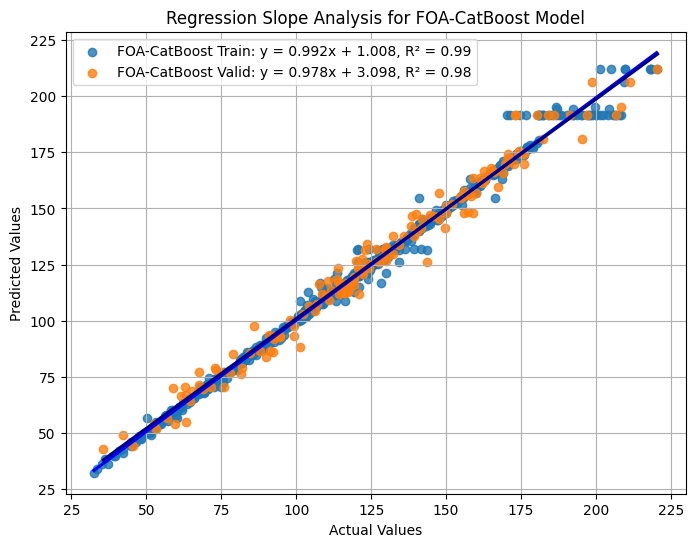

In [13]:
# Calculate regression for CatBoost on Training and Validation sets
slope_catboost_train, intercept_catboost_train, _, _, _ = linregress(y_train, y_train_pred)
slope_catboost_valid, intercept_catboost_valid, _, _, _ = linregress(y_valid, y_valid_pred)
r2_catboost_train = r2_score(y_train, y_train_pred)
r2_catboost_valid = r2_score(y_valid, y_valid_pred)

# Plot for CatBoost Model
plt.figure(figsize=(8, 6))
sns.regplot(x=y_train, y=y_train_pred, ci=None, line_kws={"color": "orange"}, label=f"CatBoost Train: y = {slope_catboost_train:.3f}x + {intercept_catboost_train:.3f}, R² = {r2_catboost_train:.2f}")
sns.regplot(x=y_valid, y=y_valid_pred, ci=None, line_kws={"color": "red"}, label=f"CatBoost Valid: y = {slope_catboost_valid:.3f}x + {intercept_catboost_valid:.3f}, R² = {r2_catboost_valid:.2f}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Regression Slope Analysis for CatBoost Model")
plt.legend()
plt.grid(True)
plt.show()

# Calculate regression for FOA-CatBoost on Training and Validation sets
slope_foa_catboost_train, intercept_foa_catboost_train, _, _, _ = linregress(y_train, y_train_pred_best)
slope_foa_catboost_valid, intercept_foa_catboost_valid, _, _, _ = linregress(y_valid, y_valid_pred_best)
r2_foa_catboost_train = r2_score(y_train, y_train_pred_best)
r2_foa_catboost_valid = r2_score(y_valid, y_valid_pred_best)

# Plot for FOA-CatBoost Model
plt.figure(figsize=(8, 6))
sns.regplot(x=y_train, y=y_train_pred_best, ci=None, line_kws={"color": "blue"}, label=f"FOA-CatBoost Train: y = {slope_foa_catboost_train:.3f}x + {intercept_foa_catboost_train:.3f}, R² = {r2_foa_catboost_train:.2f}")
sns.regplot(x=y_valid, y=y_valid_pred_best, ci=None, line_kws={"color": "darkblue"}, label=f"FOA-CatBoost Valid: y = {slope_foa_catboost_valid:.3f}x + {intercept_foa_catboost_valid:.3f}, R² = {r2_foa_catboost_valid:.2f}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Regression Slope Analysis for FOA-CatBoost Model")
plt.legend()
plt.grid(True)
plt.show()


# Shap analysis

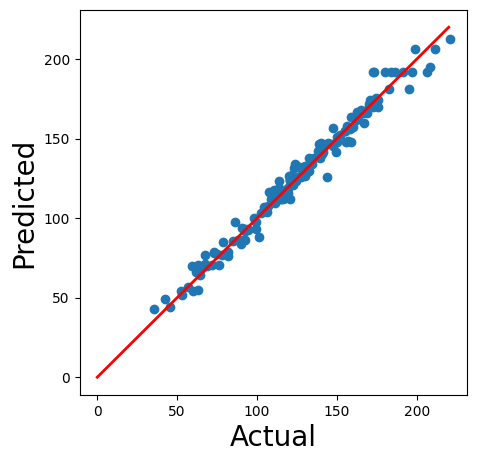

In [ ]:
# https://www.youtube.com/watch?v=L8_sVRhBDLU&list=PLqDyyww9y-1SJgMw92x90qPYpHgahDLIK&index=2
shap.initjs()



In [15]:
explainer = shap.Explainer(model)
shap_values = explainer(X_valid)

## Shap stacked force plot


## Absolute mean shap

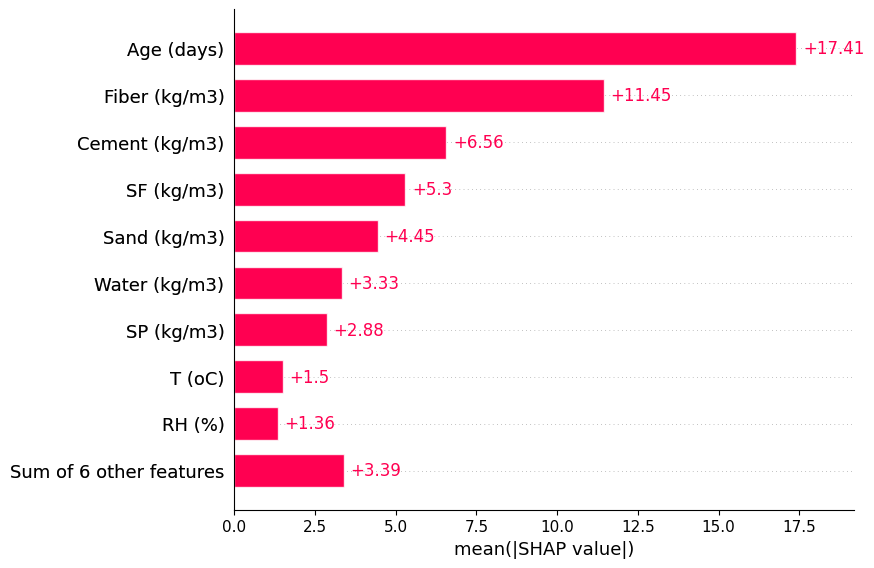

In [17]:
shap.plots.bar(shap_values)

## Shap beeswarm

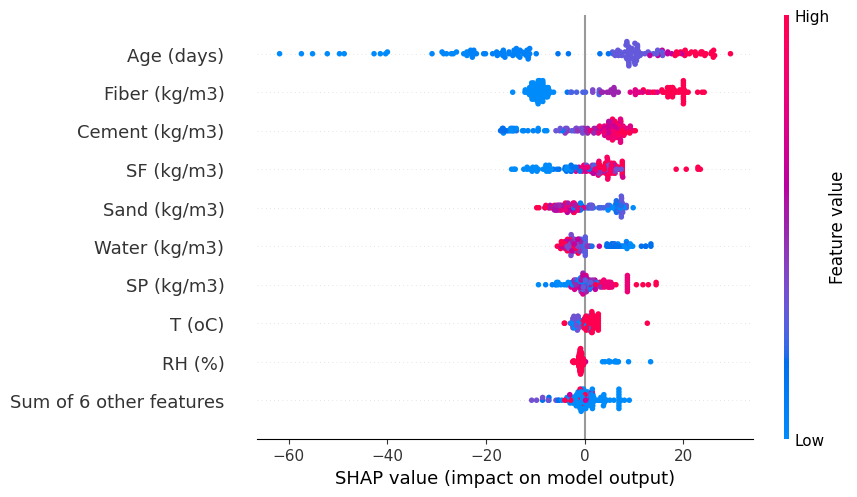

In [18]:
shap.plots.beeswarm(shap_values)